In [1]:
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from xc.tools.analysis import print_mats, decile_plot, AnalyseMatrix, load_overlap, _print_mats
from xclib.data import data_utils as du
import PIL.ImageOps as ImageOps
import scipy.sparse as sp
import numpy as np
import PIL.Image as Image
from io import BytesIO

import base64
import os
import pickle as p

from textwrap import wrap

In [2]:
work_dir="/home/cse/phd/anz198717/scratch/XC"
dset="MM-AmazonTitles-300K"
data_dir=f"{work_dir}/data/{dset}"
score_mat_dir=f"{work_dir}/score_mats/{dset}"
os.makedirs(score_mat_dir, exist_ok=True)

In [3]:
_topk=5

raw_images=f"{data_dir}/images"
k = 5
A, B = 0.6, 2.6

tst_map = list(map(lambda x: x.strip(), open(f"{data_dir}/raw_data/test.raw.txt", "r").readlines()))
lbl_map = list(map(lambda x: x.strip(), open(f"{data_dir}/raw_data/label.raw.txt", "r").readlines()))

trn_y = du.read_sparse_file(f"{data_dir}/trn_X_Y.txt")
tst_y = du.read_sparse_file(f"{data_dir}/tst_X_Y.txt")

trn_imgs, lbl_imgs = None, None,
if os.path.exists(f"{data_dir}/images/label.img.bin.npz"):
    lbl_imgs = sp.load_npz(f"{data_dir}/images/label.img.bin.npz")
trn_imgs = sp.load_npz(f"{data_dir}/images/train.img.bin.npz")
tst_imgs = sp.load_npz(f"{data_dir}/images/test.img.bin.npz")
filter_items = load_overlap(f"{data_dir}/filter_labels_test.txt")
imgs = open(f"{data_dir}/images/img.bin", "r")

In [4]:
score_mats = {
    "MUFIN-light": f"{score_mat_dir}/MUFIN-light/score.npz",
    "MUFIN-onlyimg": f"{score_mat_dir}/MUFIN-onlyimg/score.npz",
    "NGAME": f"{score_mat_dir}/NGAME/score.npz"
}
score_mats = AnalyseMatrix(score_mats, _topk, filter_items)
sorted_mats = ["MUFIN-light", "MUFIN-onlyimg", "NGAME"]
strict_mats = [-1, 2, 1]

loading: 100%|██████████| 3/3 [01:01<00:00, 20.37s/it]


In [5]:
print_mats(score_mats, sorted_mats, strict_mats, _topk, tst_map, lbl_map,
           tst_y, trn_y, out_file=f"{score_mat_dir}/output.txt")

Printing: 100%|██████████| 169/169 [00:00<00:00, 647.22it/s]


computing: 100%|██████████| 3/3 [00:00<00:00, 393.66it/s]


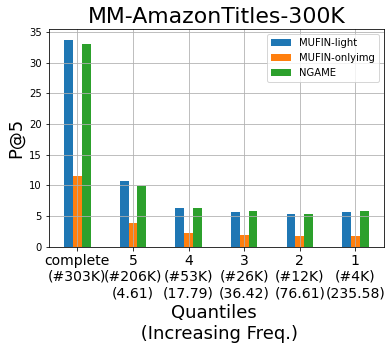

In [6]:
decile_plot(score_mats, sorted_mats, _topk, 5, tst_y, trn_y, metric="P",
            title="MM-AmazonTitles-300K", out_file=f"{score_mat_dir}/decile_P_{_topk}.pdf")

In [16]:
def fancy_stack(items, border=1):
    len_items = len(items)
    if len_items == 1:
        return items[0]
    _size = round(np.sqrt(len_items))
    if _size*_size == len_items:
        size_r, size_c = _size, _size
    else:
        size_r, size_c = _size, np.ceil(len_items/_size)
        size_r, size_c = min(size_r, size_c), max(size_r, size_c)
    size_r, size_c = int(size_r), int(size_c)
    w, h = items[0].shape[0], items[0].shape[1]
    vline = np.uint8(np.ones((w, border, 3)))
    empty = np.ones((items[0].shape[0], items[0].shape[1], 3))*255
    empty = np.uint8(empty)
    for _ in range(int(size_r*size_c - len_items)):
        items.append(empty)
    k = 0
    stacks = []
    for _r in range(0, len(items), size_c):
        _items = [items[_r]]
        for b in range(1, size_c):
            _items.append(vline)
            _items.append(items[_r+b])
        _items.append(vline)
        _stack = np.hstack(_items)
        stacks.append(_stack)
    hline = np.uint8(np.ones((border, stacks[0].shape[1], 3)))
    vstacks = [stacks[0]]
    for _row in stacks[1:]:
        vstacks.append(hline)
        vstacks.append(_row)
    return np.vstack(vstacks)
        
def read_img_bin(dat: str):
    return np.asarray(Image.open(BytesIO(base64.b64decode(dat))), dtype=np.uint8)

def show_data(idxs, txt_mat, img_mat, imgs, prefix="", output_path=None, size=(128, 128)):
    for idx in idxs:
        print(prefix, idx)
        items = []
        title = txt_mat[idx].split("->", 1)[1].strip()
        for im_index, img_idx in enumerate(img_mat[idx].data):
            imgs.seek(int(img_idx)-1)
            _, b64_img = imgs.readline().split("\t")
            limg = read_img_bin(b64_img).copy()
            items.append(np.asarray(limg))
            imgs.seek(0)
        items = fancy_stack(items)
        plt.figure()
        title = r"$\mathtt{%s}$: %s"%(prefix, "\n".join(wrap(title, 40)))
        plt.xlabel(title, fontsize=14)
        plt.gca().xaxis.set_label_position("top")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(items)
        if output_path is not None:
            os.makedirs(output_path, exist_ok=True)
            plt.savefig(f"{output_path}/{prefix}_{idx}.png", bbox_inches='tight', dpi=200, pad_inches=0.0)
        plt.show()

X 62352


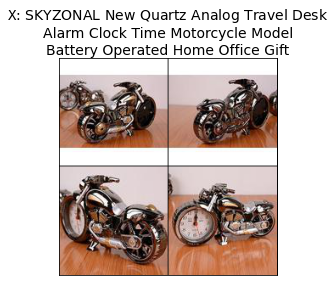

In [17]:
# to_puru = [39947]
to_puru = [62352]
x = to_puru[0]
show_data(to_puru, tst_map, tst_imgs, imgs, "X", f"{score_mat_dir}/data/{x}")

[ 26539  34549  37713  39055  48514  91986 101521 101522 107696 118525
 119837 125167 137529 143871] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Z_{+} 26539


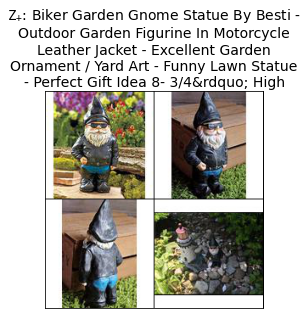

Z_{+} 34549


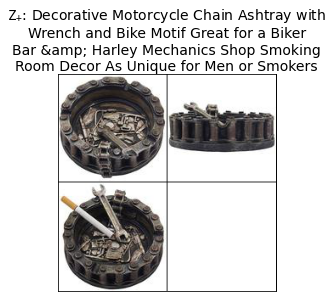

Z_{+} 37713


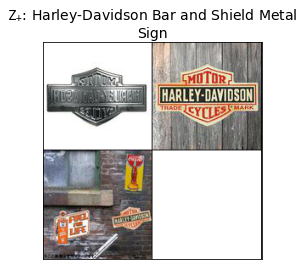

Z_{+} 39055


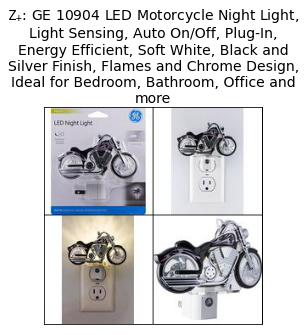

Z_{+} 48514


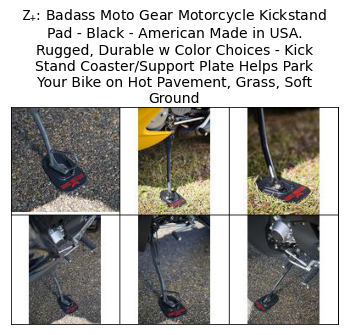

Z_{+} 91986


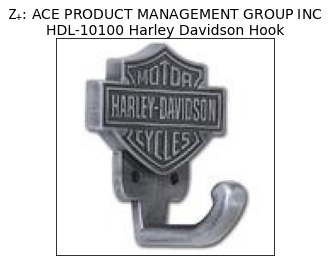

Z_{+} 101521


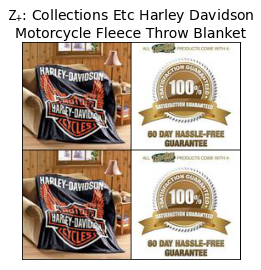

Z_{+} 101522


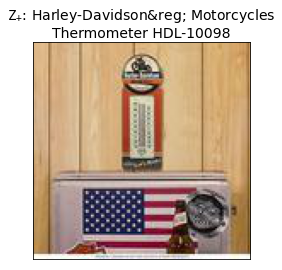

Z_{+} 107696


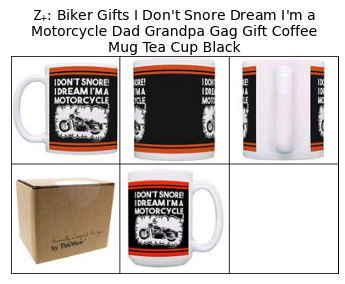

Z_{+} 118525


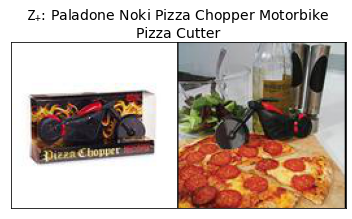

Z_{+} 119837


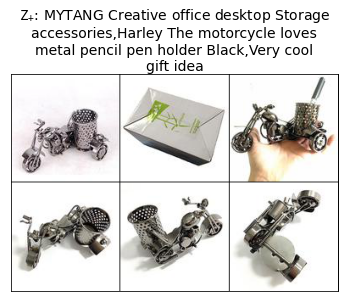

Z_{+} 125167


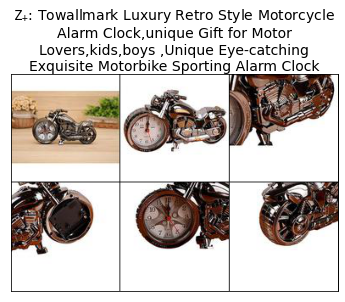

Z_{+} 137529


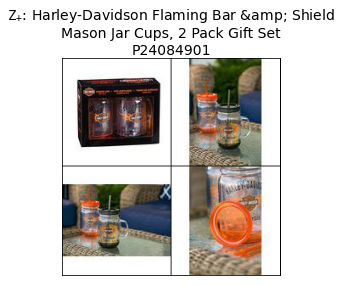

Z_{+} 143871


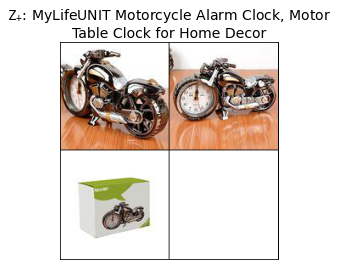

In [18]:
key = "GroundTurth"
if lbl_imgs is not None:
    for x in to_puru:
        idx = tst_y[x].indices
        flg = np.ravel(tst_y[x, idx].todense())
        print(idx, flg)
        p_lidx = idx[flg==1]
        show_data(p_lidx, lbl_map, lbl_imgs, imgs, "Z_{+}", f"{score_mat_dir}/data/{x}/{key}")
        p_lidx = idx[flg==0]
        show_data(p_lidx, lbl_map, lbl_imgs, imgs, "Z_{-}", f"{score_mat_dir}/data/{x}/{key}")

[ 23591  30033  40615  40634 158804] [0. 0. 0. 0. 0.]
Z_{-} 23591


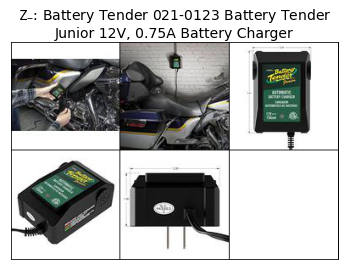

Z_{-} 30033


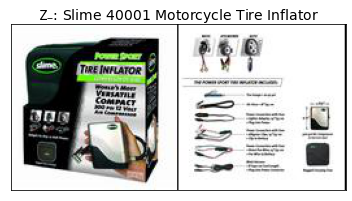

Z_{-} 40615


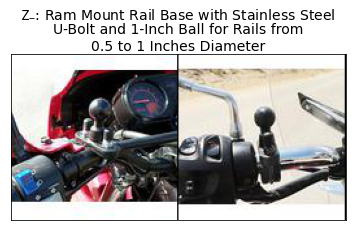

Z_{-} 40634


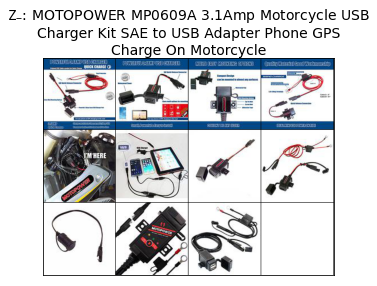

Z_{-} 158804


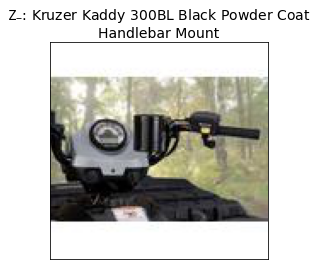

In [21]:
key = "MUFIN-light"
key = "MUFIN-onlyimg"
key = "NGAME"

if lbl_imgs is not None:
    for x in to_puru:
        idx = score_mats[key][x].indices
        flg = np.ravel(tst_y[x, idx].todense())
        print(idx, flg)
        p_lidx = idx[flg==1]
        show_data(p_lidx, lbl_map, lbl_imgs, imgs, "Z_{+}", f"{score_mat_dir}/data/{x}/{key}")
        p_lidx = idx[flg==0]
        show_data(p_lidx, lbl_map, lbl_imgs, imgs, "Z_{-}", f"{score_mat_dir}/data/{x}/{key}")

In [ ]:

def get_img_data(content, score_mats, tst_mat, lbl_mat, imgs, tst_y, lbl_txt, target_key="MUFIN", size=(128, 128)):
    for idx in range(len(content)):
        items = []
        for im_index, img_idx in enumerate(tst_mat[content[idx]["index"]].data):
            imgs.seek(int(img_idx)-1)
            _, b64_img = imgs.readline().split("\t")
            limg = read_img_bin(b64_img).copy()
            items.append(np.asarray(limg))
            imgs.seek(0)
        items = fancy_stack(items)
        content[idx]["doc_img"] = items
        if lbl_mat is not None:
            lidx = score_mats[target_key][content[idx]["index"]].indices
            print(lidx)
            lflg = np.ravel(tst_y[content[idx]["index"], lidx].todense())
            lbl_content = {}
            for blah, _idx in enumerate(lidx):
                items = []
                for im_index, img_idx in enumerate(lbl_mat[idx].data):
                    imgs.seek(int(img_idx)-1)
                    _, b64_img = imgs.readline().split("\t")
                    limg = read_img_bin(b64_img).copy()
                    items.append(np.asarray(limg))
                    imgs.seek(0)
                items = fancy_stack(items)
                lbl_content[lbl_txt[_idx].split("->", 1)[0]] = {"flag": lflg[blah], "img": items}
            content[idx]["lbl_img"] = lbl_content
    return content

In [ ]:
doc_frq = np.ravel(trn_y.sum(axis=0))
datas = _print_mats(score_mats, to_puru, doc_frq, tst_map, lbl_map, tst_y, out_file=None)
datas = get_img_data(datas, score_mats, tst_imgs, lbl_imgs, imgs, tst_y, lbl_map)
p.dump(datas, open(f"{score_mat_dir}/data.pkl", "wb"))

In [ ]:
def print_dats(data, output_path=None):
    os.makedirs(output_path, exist_ok=True)
    f = open(f"{output_path}/print_log.txt", "w")
    for item in data:
        print(item["title"])
        plt.figure()
        title = item["title"].split("->", 1)[1].strip()
        title = r"$\mathtt{%s}$: %s"%("X", "\n".join(wrap(title, 40)))
        plt.xlabel(title, fontsize=14)
        plt.gca().xaxis.set_label_position("top")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item["doc_img"])
        print(f"{item['index']}->{item['title']}", file=f)
        print("-".join([""]*80), file=f)
        print(", ".join(item["gt"]), file=f)
        print("-".join([""]*80), file=f)
        for key in item["preds"].keys():
            print(key +" "+ item["preds"][key]["score"] + " : " + ", ".join(item["preds"][key]["items"]), file=f)
            print("-".join([""]*80), file=f)
        print("=".join([""]*80), file=f)
        if output_path is not None:
            folder = item["title"].split("->", 1)[0].strip().split(",")[0].strip()
            path = os.path.join(output_path, folder)
            os.makedirs(path, exist_ok=True)
            plt.savefig(f"{path}/doc.png", bbox_inches='tight', dpi=200, pad_inches=0.0)
        plt.show()
    f.close()

In [ ]:
data = p.load(open(f"{score_mat_dir}/data.pkl", "rb"))
print_dats(data, f"{score_mat_dir}/set_outputs")